# CS584 Assignment 4 by Linsen Li

# 1. Document Classification 

In [1]:
# Read the txt file and store them as list variable
# each element in the list is a row in the previous txt file
# the txt file should be in the same dictionary as /data/file.txt
with open('./a4-data/q1/28054-0.txt', 'r') as f:
    x1 = f.readlines()

with open('./a4-data/q1/pg1661.txt', 'r') as f:
    x2 = f.readlines()
    
with open('./a4-data/q1/pg31100.txt', 'r') as f:
    x3 = f.readlines()
    

## (a) 
- Preprocess the data: build the vocabulary, tokenize, etc. Divide the data into train, validation, and test.

In [2]:
import re
import numpy as np
import pandas as pd
# Data pre-processing function
# Input:
#     text: the document
#     category: the category of the document, we assign 0, 1, 2 to this variable
#     n: the length of the paragraph, use to control the sample size,have to tune
# Return:
#     tol_num: the total number of examples for each category
#     df: the Dataframe variable after assign each paragraphs a category 
def prepare(text, category, n):
    # Divide each document into multiple paragraphs.
    s = ''.join(text)
    l = s.split('\n\n')
    l1 = [i.strip() for i in l if len(i) > n]
    # Remove punctuation, irrelevant symbols, urls, and numbers
    l2 = [re.sub('[^A-Za-z0-9]+', ' ', i).lower().strip() for i in l1]
    tol_num = len(l2)
    # Create the dataframe object
    cate_array = np.ones((tol_num,)) * category
    df = pd.DataFrame({'paragraph': l2, 'category':cate_array })
    print('The total number of examples for category ' + str(category)+ ' is: ' + str(tol_num))
    return df, tol_num

df1, num1 = prepare(x1, 0, 600)
df2, num2 = prepare(x2, 1, 200)
df3, num3 = prepare(x3, 2, 1000)

The total number of examples for category 0 is: 952
The total number of examples for category 1 is: 874
The total number of examples for category 2 is: 932


In [3]:
df = pd.concat([df1,df2,df3])
X = df['paragraph']
y = df['category']
df

,paragraph,category
0,part i book i the history of a family chapter ...,0.0
1,alexey fyodorovitch karamazov was the third so...,0.0
2,he was married twice and had three sons the el...,0.0
3,immediately after the elopement adela da ivano...,0.0
4,one would think that you d got a promotion fyo...,0.0
...,...,...
927,in spite of his being allowed once more to liv...,2.0
928,i will not say that i am disappointed my dear ...,2.0
929,the whole of lucy s behaviour in the affair an...,2.0
930,creating the works from public domain print ed...,2.0


In [17]:
from sklearn.model_selection import train_test_split             
from keras.preprocessing.text import Tokenizer                    
from keras.preprocessing.sequence import pad_sequences


sentences = X.values
y = y

sentences_train,sentences_test,y_train,y_test = train_test_split(sentences, y, test_size=0.25, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(sentences_train, y_train, test_size=0.05, random_state=1)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_validation = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1                          

# maxlen = max([len(s.split()) for s in sentences])
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_validation = pad_sequences(X_validation, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Use One hot encoding to deal with the test set
# Since test set contain 3 categories
# then [1,0,0] represent category 0
#      [0,1,0] represent category 1
#      [0,0,1] represent category 2
import numpy as np
from keras.utils import to_categorical
label_train = to_categorical(y_train)
label_validation = to_categorical(y_val)
label_test = to_categorical(y_test)

In [5]:
print('Shape of x_train: ' + str(X_train.shape))
print('Shape of y_train: ' + str(label_train.shape))
print('Shape of x_validation: ' + str(X_validation.shape))
print('Shape of y_validation: ' + str(label_validation.shape))
print('Shape of x_test: ' + str(X_test.shape))
print('Shape of y_test: ' + str(label_test.shape))

Shape of x_train: (1964, 100)
Shape of y_train: (1964, 3)
Shape of x_validation: (104, 100)
Shape of y_validation: (104, 3)
Shape of x_test: (690, 100)
Shape of y_test: (690, 3)


## (b),(c),(d),(e)
- Initialize parameters for the model. Implement the forward pass for the model. Use an embedding layer as the first layer of your network (e.g. tf.nn.embedding lookup). Set zero paddings to the input matrix. Use at least two convolutional layers (each layer includes convolution, activation, and maxpooling).
- Choose and report the number of filters and the filter size for your CNN.
- Calculate the loss of the model (cross-entropy loss is suggested). Set up the training step:
  use a learning rate of 1e − 3 and an Adam optimizer.
- Train you model and report the recall and precision of each class on test data. Tune the
  parameters to achieve the best performance you can.


In [10]:
from keras.models import Model
from keras.layers import Dense, Activation, BatchNormalization,Flatten,Dropout,Embedding,Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import optimizers
inputs = Input(shape=(maxlen,))
embedding = Embedding(vocab_size, 100)(inputs)
# channel 1
conv1 = Conv1D(filters=12, kernel_size=3,activation='relu')(embedding)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)
# channel 2
conv2 = Conv1D(filters=12, kernel_size=2,activation='relu')(embedding)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)
# channel 3
conv3 = Conv1D(filters=12, kernel_size=4,activation='relu')(embedding)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)
# merge
merged = concatenate([flat1, flat2, flat3])
# interpretation
#drop4 = Dropout(0.5)(merged)
dense1 = Dense(10, activation='relu')(merged)
outputs = Dense(3, activation='softmax')(dense1)
model = Model(inputs=[inputs], outputs=outputs)
# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model.summary())


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 100, 100)     1555500     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 98, 12)       3612        embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 99, 12)       2412        embedding_8[0][0]                
____________________________________________________________________________________________

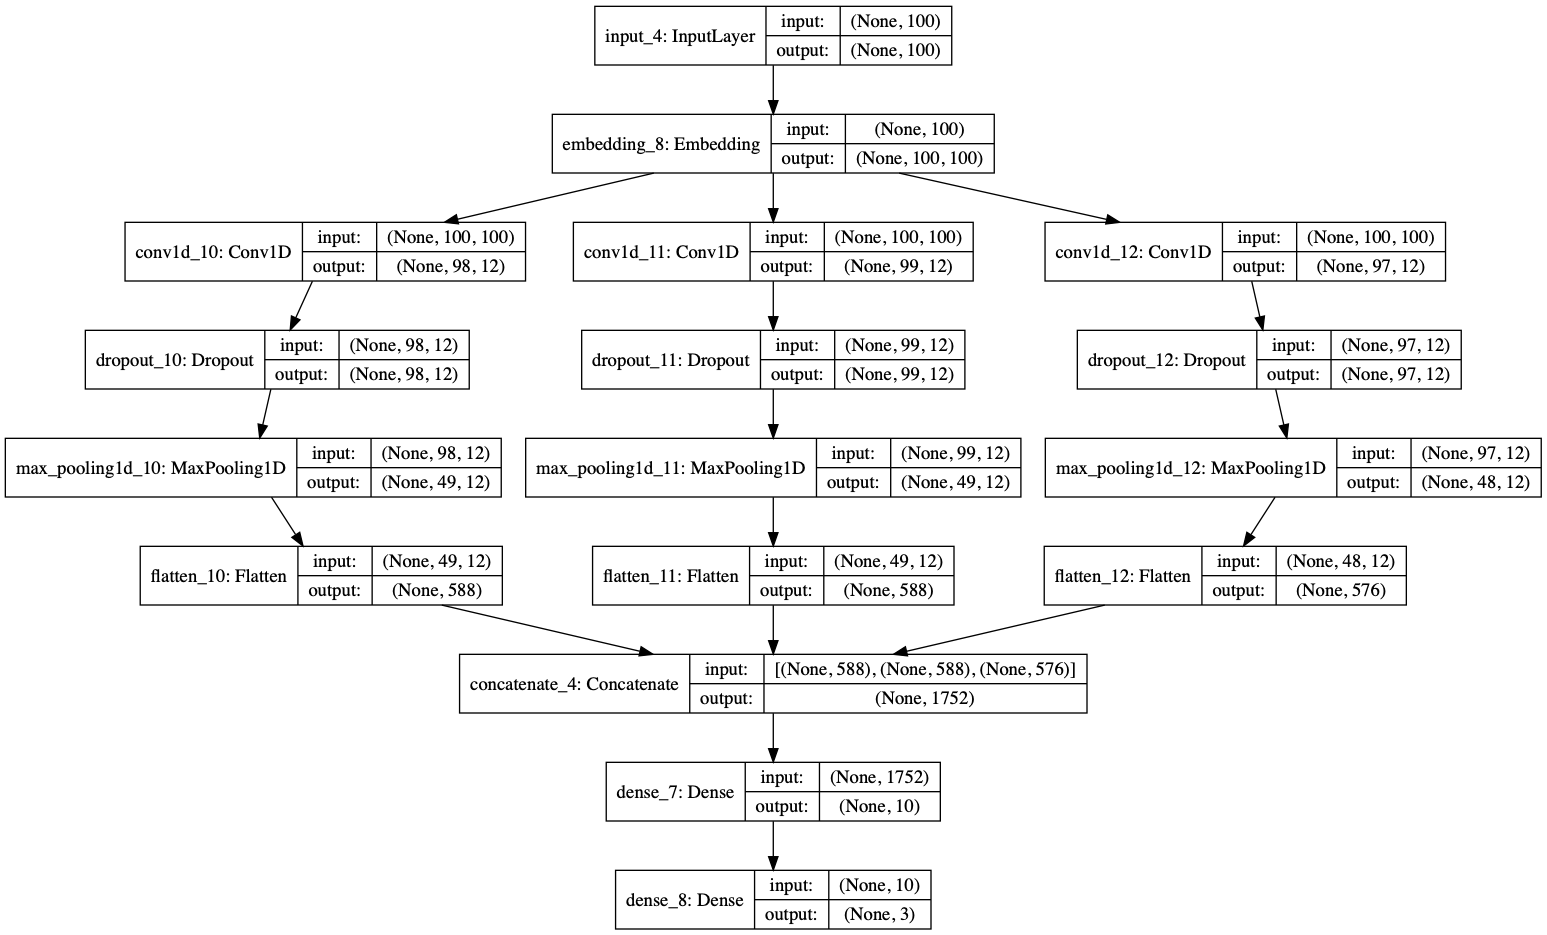

In [18]:
# Show the structure of the nerual network
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='multichannel_task1.png')

In [13]:
history = model.fit([X_train], label_train, epochs=10,validation_data=([X_validation], label_validation), batch_size=16)

Train on 1964 samples, validate on 104 samples
Epoch 1/10
1964/1964 [==============================] - 3s 2ms/step - loss: 0.2734 - accuracy: 0.9211 - val_loss: 0.2172 - val_accuracy: 0.9519
Epoch 2/10
1964/1964 [==============================] - 3s 2ms/step - loss: 0.0436 - accuracy: 0.9924 - val_loss: 0.1332 - val_accuracy: 0.9519
Epoch 3/10
1964/1964 [==============================] - 3s 2ms/step - loss: 0.0246 - accuracy: 0.9944 - val_loss: 0.1213 - val_accuracy: 0.9519
Epoch 4/10
1964/1964 [==============================] - 3s 2ms/step - loss: 0.0174 - accuracy: 0.9969 - val_loss: 0.1081 - val_accuracy: 0.9519
Epoch 5/10
1964/1964 [==============================] - 3s 2ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.1025 - val_accuracy: 0.9615
Epoch 6/10
1964/1964 [==============================] - 3s 2ms/step - loss: 0.0105 - accuracy: 0.9959 - val_loss: 0.0953 - val_accuracy: 0.9712
Epoch 7/10
1964/1964 [==============================] - 3s 2ms/step - loss: 0.0090 - accu

In [14]:
loss_and_acc = model.evaluate([X_test], label_test)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

690/690 [==============================] - 0s 153us/step
loss = 0.11386912482912126
accuracy = 0.9550724625587463


In [16]:
# Report the recall and precision for each category on the test sets
from sklearn.metrics import classification_report
y_pred_NN = model.predict([X_test], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred_NN, axis=1)
print(classification_report(y_test, y_pred_bool))

690/690 [==============================] - 0s 284us/step
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       231
         1.0       1.00      0.92      0.96       219
         2.0       0.94      0.98      0.96       240

    accuracy                           0.96       690
   macro avg       0.96      0.95      0.96       690
weighted avg       0.96      0.96      0.96       690



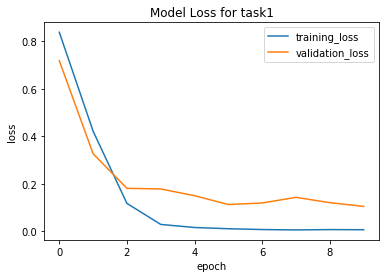

In [260]:
# Plot training loss and validation loss every epoches
# summarize history for loss
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for task1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'], loc='upper right')
plt.show()

# 2. Sentiment Analysis 

## (a) 
- Preprocess the data: extract the review text from <review text>, build the vocabulary, tokenize, etc. Divide the data into train, validation, and test.


In [19]:
# Read the txt file and store them as list variable
with open('./a4-data/q2/negative_review.txt', encoding="utf8", errors='ignore') as f:
    negative = [i.strip() for i in f.readlines()]
with open('./a4-data/q2/positive_review.txt', encoding="utf8", errors='ignore') as f:
    positive = [i.strip() for i in f.readlines()]

In [20]:
# Define a function to extract the review text from <review_text>
def review_text_extract(text_list):
    reviews = list()
    for i in range(len(text_list)):
        if text_list[i] == '<review_text>':
            k = 1
            while text_list[i+k] != '</review_text>':
                k += 1
            review = ''.join(text_list[i+1:i+k])
            reviews.append(review)
    return reviews

In [21]:
# Receive the positive reviews
positive_reviews = review_text_extract(positive)
len(positive_reviews)

1000

In [22]:
# Receive the negative reviews
negative_reviews = review_text_extract(negative)
len(negative_reviews)

1000

In [23]:
# Define a function to build the dataframe object
# 1 represent positive, 0 represent negative
def q2_to_df(p,n):
    cate_array_positive = np.ones((len(p),)) 
    cate_array_negative = np.zeros((len(n),))     
    df_positive = pd.DataFrame({'reviews': p, 'category':cate_array_positive})
    df_negative = pd.DataFrame({'reviews': n, 'category':cate_array_negative})
    df = pd.concat([df_positive,df_negative])
    return df
    

In [24]:
import numpy as np
import pandas as pd
# Show the dataframe
df2 = q2_to_df(positive_reviews,negative_reviews)
df2

,reviews,category
0,"Bridget Jones, modern day woman, brillant and ...",1.0
1,I am ordering copies for all 23 middle school ...,1.0
2,As a casual piano player and a Broadway fanati...,1.0
3,This is one of the best biographies I have eve...,1.0
4,"I read this book many, many years ago on a ver...",1.0
...,...,...
995,This book provides excellent information about...,0.0
996,I really didn't enjoy this book. I am half It...,0.0
997,This book is a place to start at best. The ma...,0.0
998,I was barely able to finish this book. Armstro...,0.0


In [25]:
# Define a function to pre-processing the df 
# including build the vocabulary, tokenize, word to sequence
# input:  df
# output: x_train, y_train, x_val, y_val,x_test, y_test, (vocab_size, maxlen)
import numpy as np
from keras.utils import to_categorical
def text_preprocessing(df):
    X = df.iloc[:,0]
    y = df.iloc[:,1]
    sentences = X.values
    y = y
    sentences_train,sentences_test,y_train,y_test = train_test_split(sentences, y, test_size=0.1, random_state=5)
    X_train, X_val, y_train, y_val = train_test_split(sentences_train, y_train, test_size=0.1, random_state=2)

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_validation = tokenizer.texts_to_sequences(X_val)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1                          

    maxlen = 100

    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_validation = pad_sequences(X_validation, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    print('Shape of x_train: ' + str(X_train.shape))
    print('Shape of y_train: ' + str(y_train.shape))
    print('Shape of x_validation: ' + str(X_validation.shape))
    print('Shape of y_validation: ' + str(y_val.shape))
    print('Shape of x_test: ' + str(X_test.shape))
    print('Shape of y_test: ' + str(y_test.shape))
    return X_train,y_train, X_validation,y_val,X_test, y_test, (vocab_size, maxlen)

# This one_hot encoding function is to tramsform the y to one-hot vector
def one_hot(y):
    return to_categorical(y)



## (b),(c),(d),(e)
- Initialize parameters for the model. Implement the forward pass for the model. Use an embedding layer as the first layer of your network (e.g. tf.nn.embedding lookup). Set zero paddings to the input matrix. Use at least two convolutional layers (each layer includes convolution, activation, and maxpooling).
- Choose and report the number of filters and the filter size for your CNN.
- Calculate the loss of the model (binary cross-entropy loss is suggested). Choose appropriate output function. Set up the training step including learning rate and optimizer.
- Train you model and report the recall and precision of each class on test data. Tune the
  parameters to achieve the best performance you can.



In [60]:
# Define a function to built the convoluted channel
def convolution(vocab_size, maxlen):
    inputs = Input(shape=(maxlen,))
    embedding = Embedding(vocab_size, 50)(inputs)
    # channel 1
    conv1 = Conv1D(filters=8, kernel_size=3,activation='relu')(embedding)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    #conv2 = Conv1D(filters=8, kernel_size=2,activation='relu')(embedding)
    #drop2 = Dropout(0.5)(conv2)
    #pool2 = MaxPooling1D(pool_size=2)(drop2)
    #flat2 = Flatten()(pool2)
    # channel 3
    conv3 = Conv1D(filters=16, kernel_size=4,activation='relu')(embedding)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1,flat3])
    # interpretation
    drop4 = Dropout(0.8)(merged)
    dense1 = Dense(10, activation='relu')(drop4)
    outputs = Dense(2, activation='softmax')(dense1)
    model = Model(inputs=[inputs], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())
    return model

In [61]:
# Build the model
from sklearn.model_selection import train_test_split             
from keras.preprocessing.text import Tokenizer                    
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Activation, BatchNormalization,Flatten,Dropout,Embedding,Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import optimizers
x_train, y_train, x_val, y_val,x_test, y_test, (vocab_size, maxlen) = text_preprocessing(df2)
y_train = one_hot(y_train)
y_val = one_hot(y_val)
y_test_c = one_hot(y_test)
model = convolution(vocab_size, maxlen)

Shape of x_train: (1620, 100)
Shape of y_train: (1620,)
Shape of x_validation: (180, 100)
Shape of y_validation: (180,)
Shape of x_test: (200, 100)
Shape of y_test: (200,)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 100, 50)      1058500     input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 98, 8)        1208        embedding_16[0][0]               
__________________________________________________________________________________________________
conv1d_30 (Conv1D)

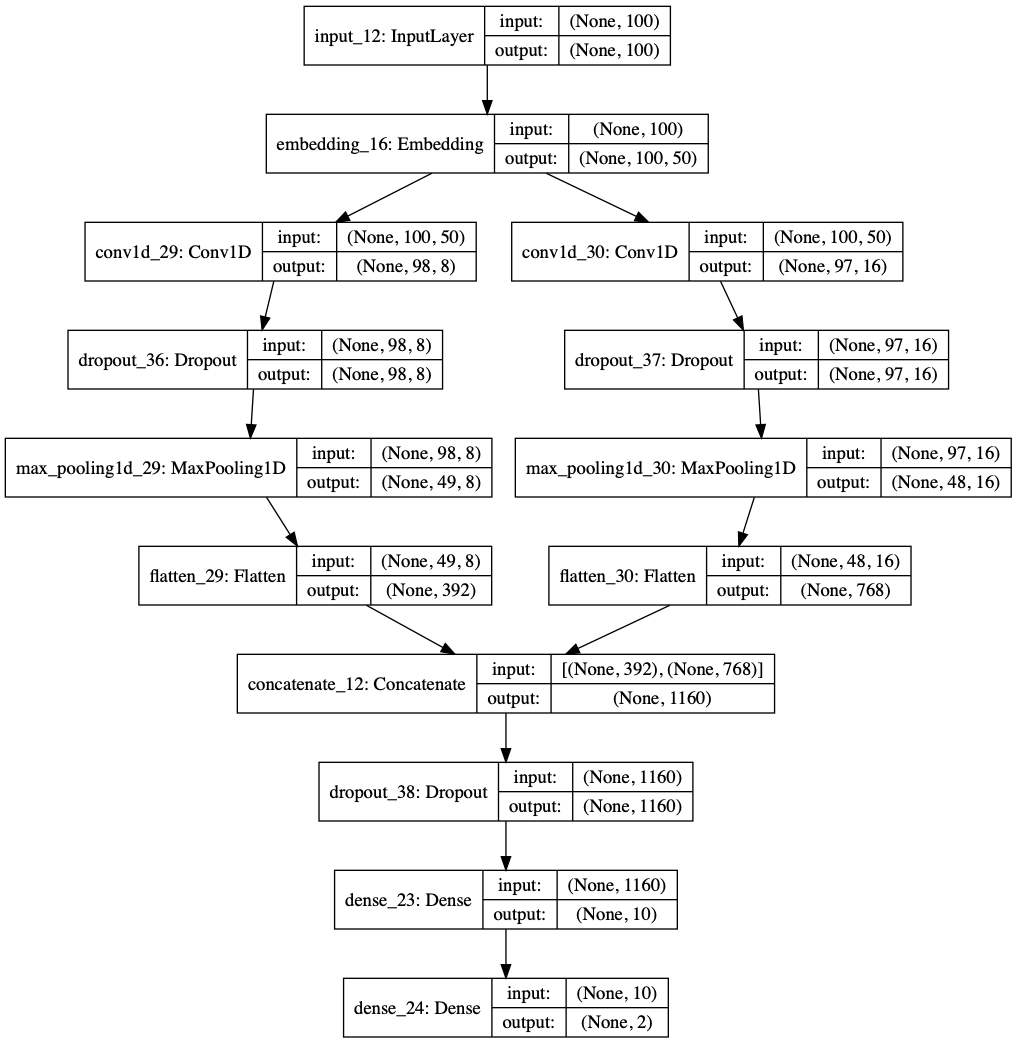

In [62]:
# Show the structure of the nerual network
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='multichannel_task2.png')

In [63]:
history = model.fit([x_train], y_train, epochs=15,validation_data=([x_val],y_val), batch_size=16)

Train on 1620 samples, validate on 180 samples
Epoch 1/15
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6957 - accuracy: 0.5025 - val_loss: 0.6915 - val_accuracy: 0.5389
Epoch 2/15
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6873 - accuracy: 0.5457 - val_loss: 0.6987 - val_accuracy: 0.4667
Epoch 3/15
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6795 - accuracy: 0.5716 - val_loss: 0.6852 - val_accuracy: 0.5389
Epoch 4/15
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6500 - accuracy: 0.6142 - val_loss: 0.6992 - val_accuracy: 0.4722
Epoch 5/15
1620/1620 [==============================] - 2s 1ms/step - loss: 0.6109 - accuracy: 0.6611 - val_loss: 0.6608 - val_accuracy: 0.6167
Epoch 6/15
1620/1620 [==============================] - 2s 1ms/step - loss: 0.5216 - accuracy: 0.7420 - val_loss: 0.6117 - val_accuracy: 0.6333
Epoch 7/15
1620/1620 [==============================] - 2s 1ms/step - loss: 0.3871 - accu

In [64]:
loss_and_acc = model.evaluate([x_test], y_test_c)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

200/200 [==============================] - 0s 98us/step
loss = 0.555784466266632
accuracy = 0.7450000047683716


In [67]:
# Report the recall and precision for each category on the test sets
from sklearn.metrics import classification_report
y_pred_NN = model.predict([x_test], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred_NN, axis=1)
print(classification_report(y_test, y_pred_bool))

200/200 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73        94
         1.0       0.76      0.75      0.76       106

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.75      0.74      0.75       200



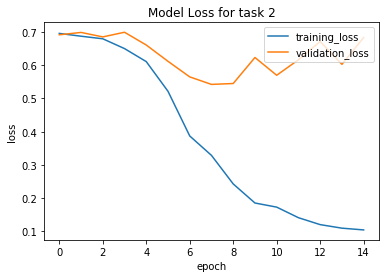

In [66]:
# Plot training loss and validation loss every epoches
# summarize history for loss
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for task 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'], loc='upper right')
plt.show()

#### Moreover: We find that our test accuacy is only around 75%. We also only use 5 epochs above since we find the overfitting problem is very serious. In order to improve our model, we use Pre-Trained GloVe Embedding 

In [292]:
# Using Pre-Trained GloVe Embedding
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding


In [293]:
df2

,reviews,category
0,"Bridget Jones, modern day woman, brillant and ...",1.0
1,I am ordering copies for all 23 middle school ...,1.0
2,As a casual piano player and a Broadway fanati...,1.0
3,This is one of the best biographies I have eve...,1.0
4,"I read this book many, many years ago on a ver...",1.0
...,...,...
995,This book provides excellent information about...,0.0
996,I really didn't enjoy this book. I am half It...,0.0
997,This book is a place to start at best. The ma...,0.0
998,I was barely able to finish this book. Armstro...,0.0


In [294]:
docs = df2['reviews']
labels = array(df2['category'])

sentences = docs.values
y = labels
    
sentences_train,sentences_test,y_train,y_test = train_test_split(sentences, y, test_size=0.1, random_state=5)                    
maxlen = 100    
t = Tokenizer()
t.fit_on_texts(sentences_train)

x_train = t.texts_to_sequences(sentences_train)
x_test = t.texts_to_sequences(sentences_test)

vocab_size = len(t.word_index) + 1

# pad documents to a max length of 100 words
max_length = 100
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')
y_train = one_hot(y_train)
y_test_c = one_hot(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test_c.shape)

(1800, 100)
(1800, 2)
(200, 100)
(200, 2)


In [160]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [161]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [162]:
embedding_matrix.shape

(22348, 100)

In [163]:
#e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=False)

In [230]:
from keras.models import Model
from keras.layers import Dense, Activation, BatchNormalization,Flatten,Dropout,Embedding,Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import optimizers

inputs = Input(shape=(maxlen,))
# channel 1
embedding1 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputs)
conv1 = Conv1D(filters=6, kernel_size=3,activation='relu')(embedding1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)
# channel 2
embedding2 = Embedding(vocab_size, 100, weights=[embedding_matrix],trainable=False)(inputs)
conv2 = Conv1D(filters=6, kernel_size=2,activation='relu')(embedding2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)
# channel 3
embedding3 = Embedding(vocab_size, 100, weights=[embedding_matrix],trainable=False)(inputs)
conv3 = Conv1D(filters=6, kernel_size=4,activation='relu')(embedding3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)
# merge
merged = concatenate([flat1, flat2, flat3])
# interpretation
drop4 = Dropout(0.8)(merged)
dense1 = Dense(10, activation='relu')(drop4)
outputs = Dense(2, activation='softmax')(dense1)
model = Model(inputs=[inputs], outputs=outputs)
# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model.summary())



Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_112 (Embedding)       (None, 100, 100)     2234800     input_38[0][0]                   
__________________________________________________________________________________________________
embedding_113 (Embedding)       (None, 100, 100)     2234800     input_38[0][0]                   
__________________________________________________________________________________________________
embedding_114 (Embedding)       (None, 100, 100)     2234800     input_38[0][0]                   
___________________________________________________________________________________________

In [233]:
# fit the model
model.fit(x_train, y_train, epochs=100, validation_split=0.2,verbose=1)


Train on 1440 samples, validate on 360 samples
Epoch 1/100
1440/1440 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.75 - 1s 424us/step - loss: 0.4926 - accuracy: 0.7535 - val_loss: 0.5400 - val_accuracy: 0.7528
Epoch 2/100
1440/1440 [==============================] - 1s 409us/step - loss: 0.4856 - accuracy: 0.7681 - val_loss: 0.5190 - val_accuracy: 0.7667
Epoch 3/100
1440/1440 [==============================] - 1s 397us/step - loss: 0.4701 - accuracy: 0.7639 - val_loss: 0.4998 - val_accuracy: 0.7806
Epoch 4/100
1440/1440 [==============================] - 1s 706us/step - loss: 0.4576 - accuracy: 0.7826 - val_loss: 0.5157 - val_accuracy: 0.7806
Epoch 5/100
1440/1440 [==============================] - 1s 498us/step - loss: 0.4704 - accuracy: 0.7569 - val_loss: 0.5308 - val_accuracy: 0.7528
Epoch 6/100
1440/1440 [==============================] - 1s 645us/step - loss: 0.4638 - accuracy: 0.7750 - val_loss: 0.5295 - val_accuracy: 0.7528
Epoch 7/100
1440/1440 [======

Epoch 56/100
1440/1440 [==============================] - 1s 844us/step - loss: 0.4139 - accuracy: 0.8042 - val_loss: 0.5048 - val_accuracy: 0.7944
Epoch 57/100
1440/1440 [==============================] - 1s 714us/step - loss: 0.4139 - accuracy: 0.7958 - val_loss: 0.5061 - val_accuracy: 0.7833
Epoch 58/100
1440/1440 [==============================] - 1s 717us/step - loss: 0.4200 - accuracy: 0.8014 - val_loss: 0.5153 - val_accuracy: 0.7667
Epoch 59/100
1440/1440 [==============================] - 1s 599us/step - loss: 0.4383 - accuracy: 0.7792 - val_loss: 0.5239 - val_accuracy: 0.7611
Epoch 60/100
1440/1440 [==============================] - 1s 413us/step - loss: 0.4317 - accuracy: 0.7903 - val_loss: 0.5320 - val_accuracy: 0.7472
Epoch 61/100
1440/1440 [==============================] - 1s 429us/step - loss: 0.4246 - accuracy: 0.7833 - val_loss: 0.5174 - val_accuracy: 0.7722
Epoch 62/100
1440/1440 [==============================] - 1s 403us/step - loss: 0.4271 - accuracy: 0.7993 - val_

In [237]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [295]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [296]:
# evaluate the model
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
loss, accuracy = loaded_model.evaluate(x_test, y_test_c, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 81.999999


In [297]:
# Report the recall and precision for each category on the test sets
from sklearn.metrics import classification_report
y_pred_NN = loaded_model.predict([x_test], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred_NN, axis=1)
print(classification_report(y_test, y_pred_bool))

200/200 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

         0.0       0.80      0.83      0.81        94
         1.0       0.84      0.81      0.83       106

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200

